In [158]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

In [281]:
sector_tickers = [
    'XLE', 'XLF', 'XLK', 'XLI', 'XLP', 'XLY', 'XLU', 'XLB', 'XLRE', 'XLV'       
                 ]
print(0.025 / 100)

0.00025


In [159]:
import datetime as dt

In [191]:
data = yf.Ticker('XLE')
tm = pd.Timestamp('2018-12-21')
value = data.history("5y")
x = value.Close[1]
print(x)

52.49217224121094


In [289]:
class Balance(object):
    def __init__(self, money, commision, sector_tickers):
        self.money = money
        self.commision = commision
        self.sector_tickers_stock = dict()
        self.sector_tickers_history = dict()
        for ticker in sector_tickers:
            self.sector_tickers_stock[ticker] = 0
            self.sector_tickers_history[ticker] = yf.Ticker(ticker).history("5y")
    
    
    def buy(self, ticker, amount, price):
        self.money -= amount * price
        self.money -= amount * price * (self.commision)
        self.sector_tickers_stock[ticker] += amount
        
    
    def buy_on_money(self, ticker, money, ID):
        price = self.sector_tickers_history[ticker].Close[ID]
        self.buy(ticker, money / price, price)
        
    
    def sell(self, ticker, amount, price):
        self.money += amount * price
        self.money -= amount * price * (self.commision)
        self.sector_tickers_stock[ticker] -= amount
        
        
    def calculate(self, ID):
        money = self.money
        for ticker, amount in self.sector_tickers_stock.items():
            money += self.sector_tickers_history[ticker].Close[ID] * amount
        return money
    
    
    def stupid_rebalance(self, top_tickers, nw_money, ID):
        for ticker, amount in self.sector_tickers_stock.items():
            #print(self.sector_tickers_history[ticker][ID:ID+1])
            self.sell(ticker, amount, self.sector_tickers_history[ticker].Close[ID])
        for ticker in top_tickers:
            self.buy_on_money(ticker, nw_money / len(top_tickers), ID)
            
    
    def rebalance(self, top_tickers, nw_money, ID):
        need_amount = dict()
        for ticker in top_tickers:
            need_amount[ticker] = (nw_money / len(top_tickers)) / self.sector_tickers_history[ticker].Close[ID]
        for ticker, amount in self.sector_tickers_stock.items():
            #print(self.sector_tickers_history[ticker][ID:ID+1])
            self.sell(ticker, max(amount - need_amount.get(ticker, 0), 0), self.sector_tickers_history[ticker].Close[ID])
        for ticker in top_tickers:
            nw_amount = self.sector_tickers_stock[ticker]
            self.buy(ticker, need_amount[ticker] - nw_amount, self.sector_tickers_history[ticker].Close[ID])
        

In [290]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


def get_revenue_XL(ticker_name, N):
    data = yf.Ticker(ticker_name)
    value = data.history(period="5y")
    revenue = (value.Close - value.Close.shift(N)) / value.Close * 100
    df = pd.DataFrame(index=value.index[2*N-1:], data=
                      {
                        'Revenue': moving_average(revenue[N:], N)
                      })
    return df

made N=5, CNT=1
made N=10, CNT=1
made N=20, CNT=1
made N=5, CNT=2
made N=10, CNT=2
made N=20, CNT=2
made N=5, CNT=3
made N=10, CNT=3
made N=20, CNT=3


<ipython-input-292-8c5980f047a4>:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


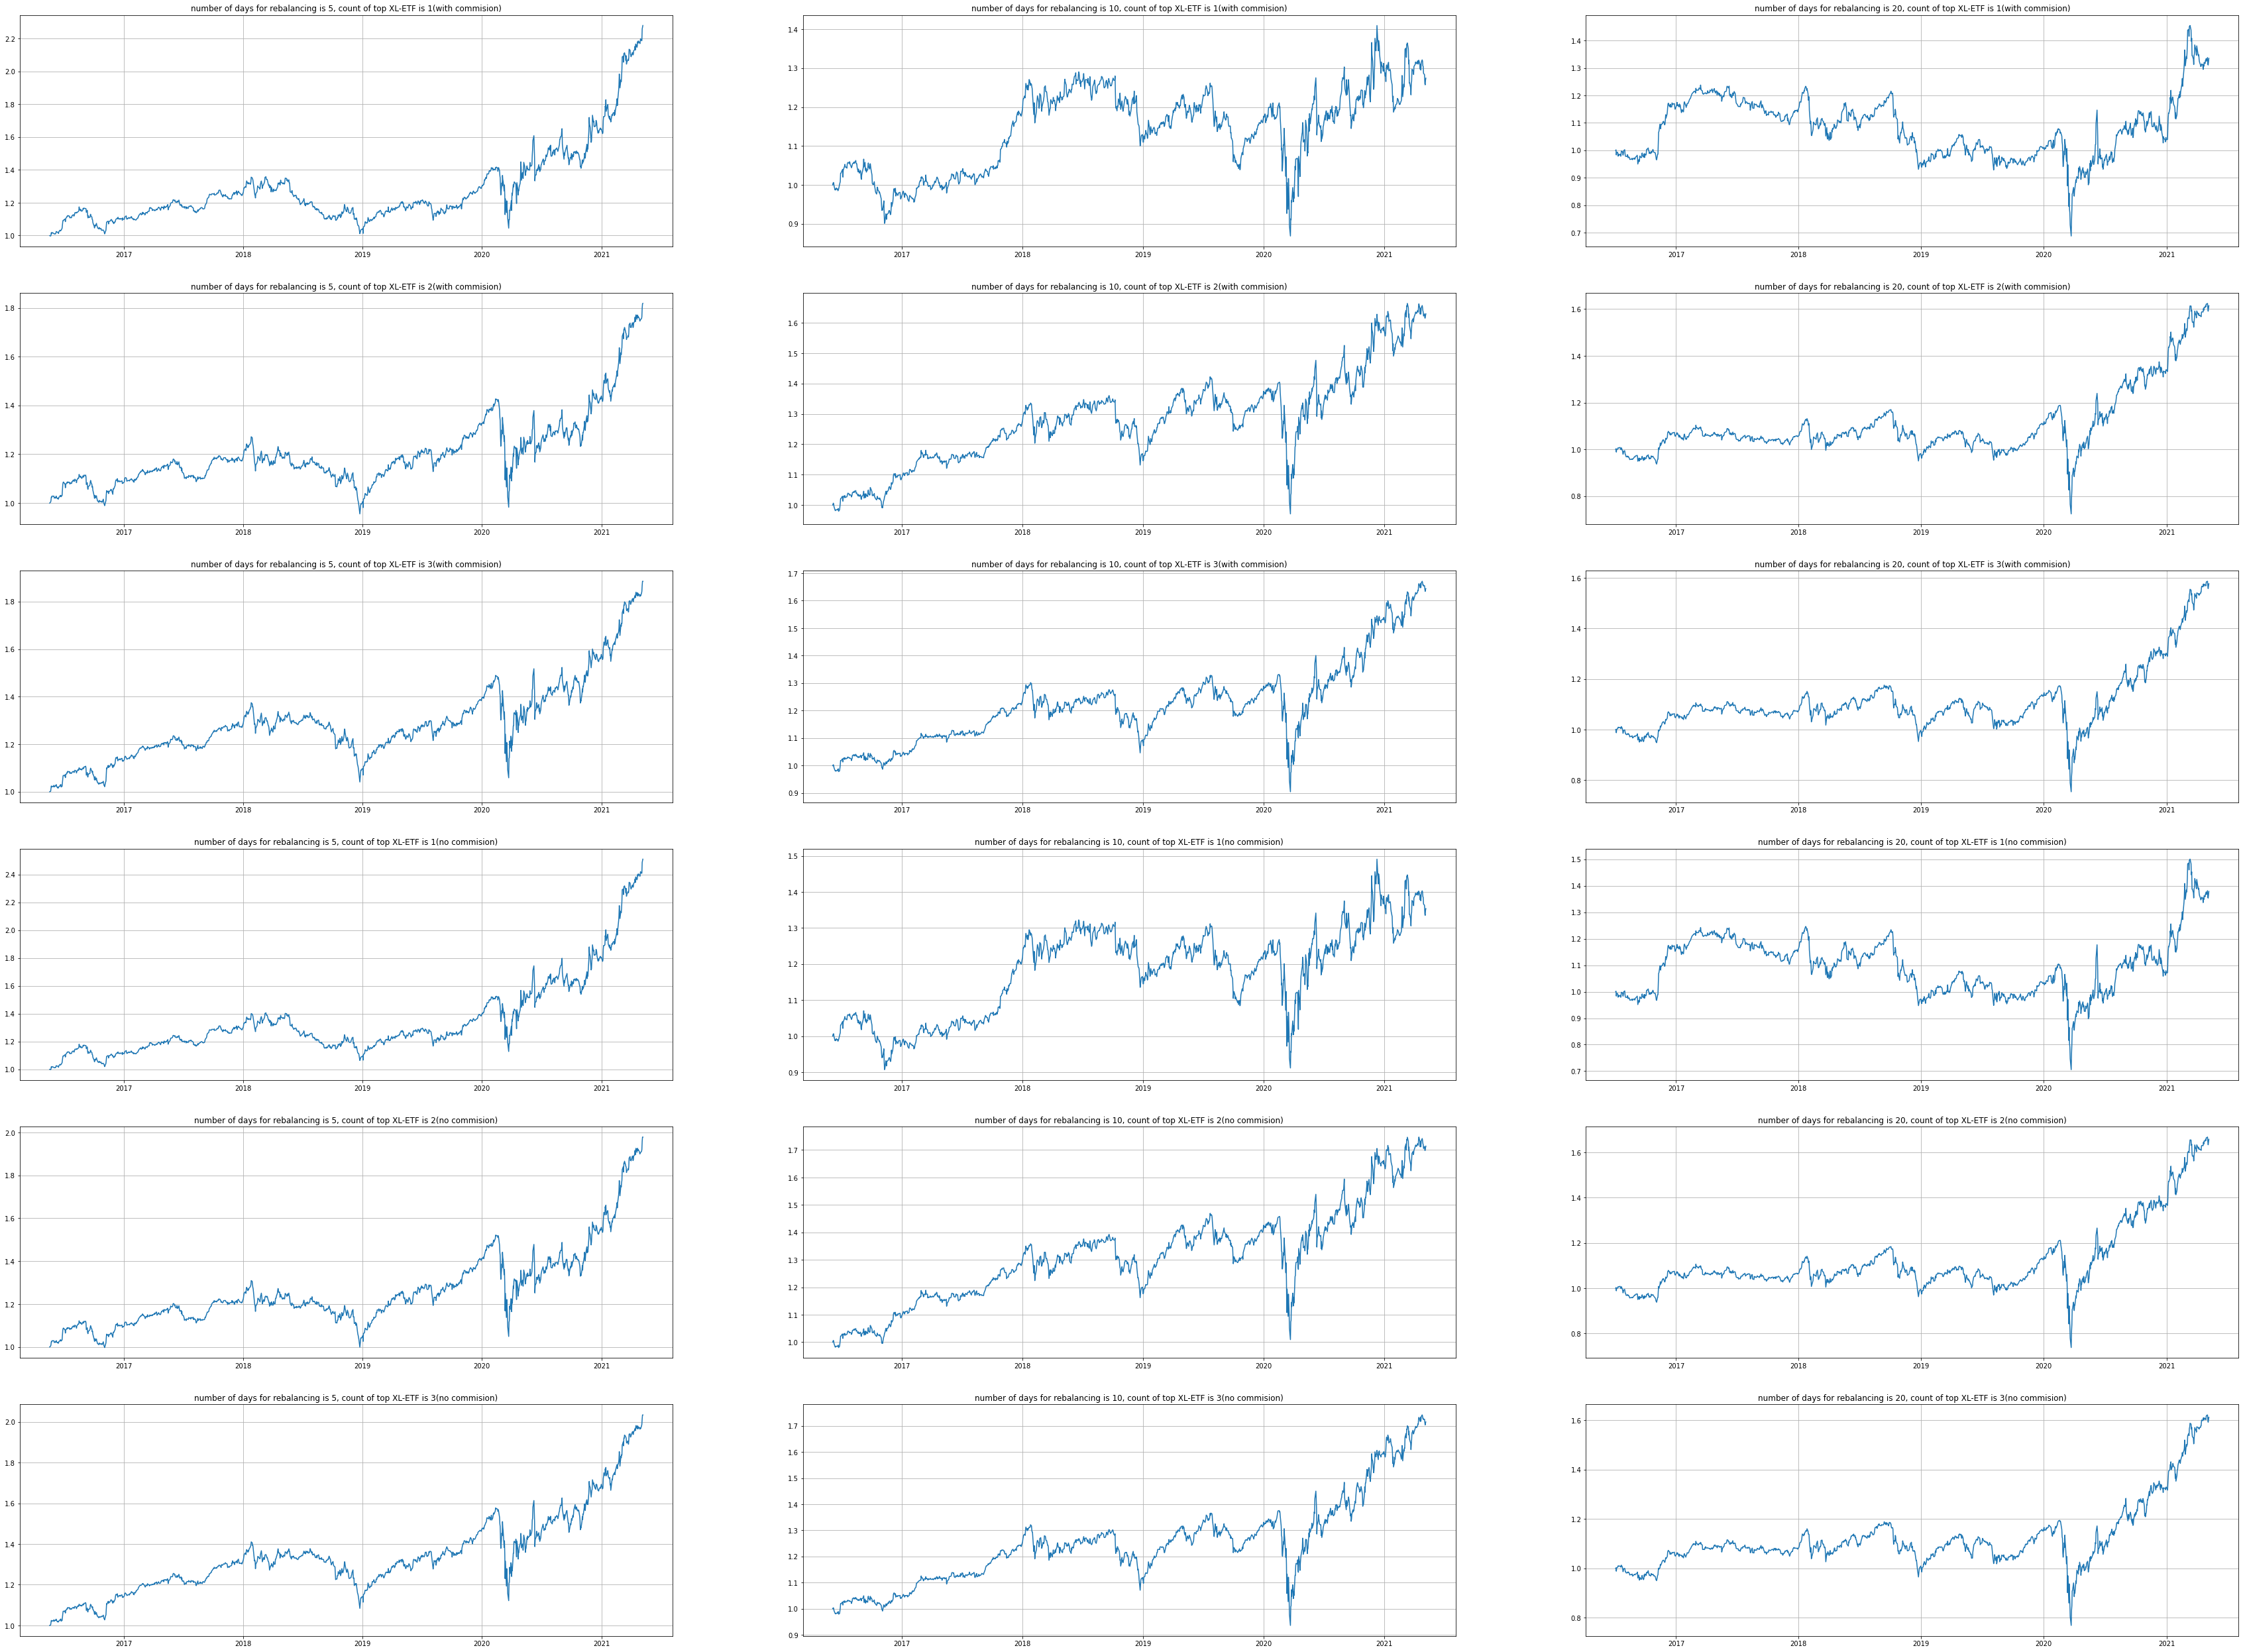

In [292]:
first_tickers = 10
array_N = [5, 10, 20]
fig, ax = plt.subplots(6, len(array_N), figsize=(10 * 6, 15 * len(array_N)))


for cnt in range(1, 4):
    for j in range(len(array_N)):
        arr = dict()
        for i in range(first_tickers):
            arr[sector_tickers[i]] = (get_revenue_XL(sector_tickers[i], array_N[j]))
            # print(arr[sector_tickers[i]].shape)

        last_rebalance = pd.Timestamp('1990-01-01')
        X_money_no_comm, X_money_comm = [], []
        balances = [Balance(1, 0.025 / 100, sector_tickers), Balance(1, 0, sector_tickers)]

        for ID in range(len(arr[sector_tickers[0]].index)):
            date = arr[sector_tickers[0]].index[ID]
            ID_IN_HISTORY = ID + array_N[j] * 2 - 1

            if (date - last_rebalance).days >= array_N[j]:
                nw_dict = dict()
                # print(date)
                for i in range(first_tickers):
                    nw_dict[sector_tickers[i]] = arr[sector_tickers[i]].Revenue[ID]
                top_cnt = sorted(nw_dict, key=nw_dict.get, reverse=True)[:cnt]
                # print(top_cnt)
                for it in range(2):
                    nw_money = balances[it].calculate(ID_IN_HISTORY)
                    balances[it].rebalance(top_cnt, nw_money, ID_IN_HISTORY)
                last_rebalance = date

            X_money_no_comm.append(balances[1].calculate(ID_IN_HISTORY))
            X_money_comm.append(balances[0].calculate(ID_IN_HISTORY))
        ax[cnt - 1][j].plot(arr[sector_tickers[0]].index, X_money_comm)
        ax[cnt - 1][j].set_title(f'number of days for rebalancing is {array_N[j]}, count of top XL-ETF is {cnt}(with commision)')
        ax[cnt - 1][j].grid()
        
        ax[cnt - 1 + 3][j].plot(arr[sector_tickers[0]].index, X_money_no_comm)
        ax[cnt - 1 + 3][j].set_title(f'number of days for rebalancing is {array_N[j]}, count of top XL-ETF is {cnt}(no commision)')
        ax[cnt - 1 + 3][j].grid()
        
        print(f'made N={array_N[j]}, CNT={cnt}')
        
        
fig.show();

In [293]:
fig.savefig('rebalance.png')